<img src="files/night_sky_eye_small.jpg">
# Image_comparison Script

Jessica Metzger (UChicago) and Jim Annis (Fermilab) 2018


To run this notebook:
  * the geckodriver executable needs to be in the environmental variable $PATH
      **export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/
  * you'll need to run 
       ** conda activate des18a"
  * and set the python path:
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python;export PYTHONPATH;
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages;export PYTHONPATH;
       
 *(to run a notebook remotely, see 
 http://home.fnal.gov/~kadrlica/fnalstart.html
 
 ## How this should work
 
 * Given a search image:
 * Select from the 200mpc catalog the likely galaxies in the image as a list of ra,dec's
 * If in panstarrs area, run the current script for each ra, dec
     ** teach this code to know where the search image is
 * If we want to see DECam template images
 ** find the DECam images that overlap (from the diffimage pipeline or from Alex)
 *** teach the code to accept a list of template DECam images
 ** teach the code to look there for those images and deal gracefully with no matches
     *** where is there? ideally all the DECam images are on disk at Fermilab. There.


In [1]:
from splinter import Browser
from selenium import webdriver
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time,os

In [2]:
# to decimal degrees
def RA_convert(RA):
    RA=RA.split(':')
    RA=[float(x) for x in RA]
    return (RA[0] + RA[1]/60. + RA[2]/3600.)*(360/24.)

# to decimal degrees
def DEC_convert(DEC):
    DEC=DEC.split(':')
    DEC=[float(x) for x in DEC]
    if DEC[0]!=0: return (abs(DEC[0]) + DEC[1]/60. + DEC[2]/3600.)*abs(DEC[0])/DEC[0]
    else: return DEC[1]/60. + DEC[2]/3600.

# save template images to new folder
def template_image(RA,DEC,size,browser,path):
    #open PS1 query
    url='http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos='+str(RA)+'%2C'+str(DEC)+\
        '&filter=i&filetypes=stack&auxiliary=data&size='+str(size)+'&output_size=0&verbose=0&autoscale=99.500000&catlist='
    browser.visit(url)
    fitsfile=browser.find_link_by_partial_text('FITS-cutout')[0]['href']
    
    newfile=fits.open(fitsfile)
    
    # write file
    new_filename=path+'RA'+str(RA)+'_DEC'+str(DEC)+'.fits'
    try: newfile.writeto(new_filename)
    except OSError:
        try:
            os.remove(new_filename)
            newfile.writeto(new_filename)
        except OSError: print('file saving error')
    return newfile[0].data

# save new cutout to new folder
def new_image(RA,DEC,size,fname,path):
    # open new file
    hdul=fits.open(fname)
    header0=hdul[0].header
    
    for hdu in hdul[1:]:
        header=hdu.header
        img=np.array(hdu.data)
        
        # Parse the WCS keywords in the primary HDU
        w = wcs.WCS(header)
    
        wcoords=np.array([RA,DEC]).reshape((1,2))
        pixs=w.all_world2pix(wcoords,1)[0]
        
        if 0<=pixs[0]<img.shape[1] and 0<=pixs[1]<img.shape[0]:
            
            cutout=np.flip(np.flip(np.array(img[int(max(0,pixs[1]-size/2.)):int(min(img.shape[0],pixs[1]+size/2.)),
                            int(max(0,pixs[0]-size/2.)):int(min(img.shape[1],pixs[0]+size/2.))]),1).transpose(),1)
            
            #write file
            new_filename=path+'RA'+str(RA)+'_DEC'+str(DEC)+'.fits'
            try: fits.writeto(new_filename, cutout, header)
            except OSError:
                try:
                    os.remove(new_filename)
                    fits.writeto(new_filename, cutout, header)
                except OSError:
                    print('file saving error with '+str(RA)+', '+str(DEC))

            return cutout
        
    return 'coordinates not found'

In [3]:
# open headless browser
# laptop
# driver=webdriver.Firefox(executable_path='/Users/jmetzger/anaconda3/bin/geckodriver')
# des machines
driver=webdriver.Firefox(executable_path='/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/geckodriver')
browser=Browser(headless=True)
# the geckodriver executable needs to be in the environmental variable $PATH
# export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/


IOError: Header missing END card.

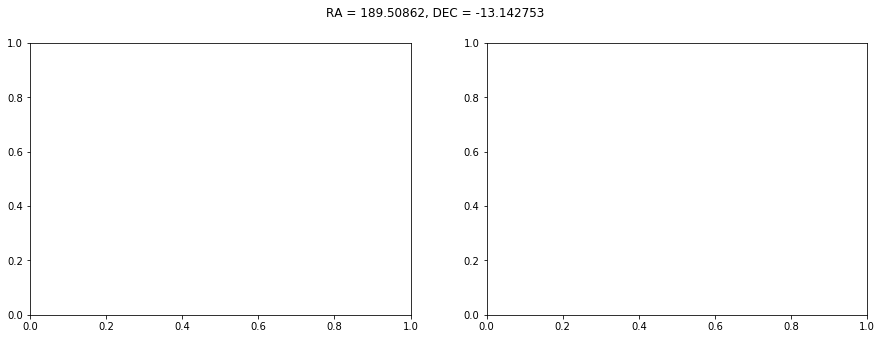

In [13]:
# example data
original_path='./original/'
template_path='./template/'
new_path='./new/'
RA_ls=[189.50862]
DEC_ls=[-13.142753]
file_ls=os.listdir(original_path)
    
pixscal=.27
for i in range(len(file_ls)):
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(RA_ls[i],6))+', DEC = '+str(round(DEC_ls[i],6)))
    
#     if not os.path.isfile(template_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    template_cutout=template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,template_path)
    
#     if not os.path.isfile(new_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    new_cutout=new_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,original_path+file_ls[i],template_path)
#     new_cutout=np.array(new_cutout)
    
    axs[0].imshow(np.log10(template_cutout-np.amin(template_cutout)+1),origin='lower',cmap='gray')
    axs[0].set_title('template')
    axs[1].imshow(np.log10(new_cutout-np.amin(new_cutout)+1),origin='lower',cmap='gray')
    axs[1].set_title('new')
    plt.show()